# Clusterization advanced
Dataset z kaggle, zawiera opinie na temat filmów, wraz z ocenami, autorami i innymi podobnymi danymi: https://www.kaggle.com/datasets/subhajournal/movie-rating

## <span style="color:#6042f5"><b>Importy

In [201]:
from collections import Counter

import unicodedata

import scipy.sparse as sp
import string
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

## <span style="color:#6042f5"><b>Data explo

In [202]:
data = pd.read_csv('./datasets/rotten_movies.csv')
data.where(pd.notnull(data), None)
data.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,audience_count
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,53.0,254287.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0,11567.0
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,53.0,14670.0
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,97.0,105000.0
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,74.0,68860.0


In [203]:
print(data.shape)

(16638, 17)


> 📝 <span style="color:lightblue">Komentarz:</span> Istotnie odnośnie danych: w kolumnie critics_consensus mamy 50% brakująych wartości. Rating to jest system wieku. A dopiero te kolumny z tomatometer_rating dają nam jakąś ocenę konkretną. Wszystkie te 'county' odnoszą się do tego ile ocen, brano pod uwagę podczas liczenia oceny. W przypadku ocen tomatometer, brane są pod uwagę opinię krytyków i znanych recenzentów, gdzie w przypadku 'audience_rating' bierzemy oceny każdego użytkownika na temat filmu. Zobaczmy jak wyglądają statystyki dla poszczególnych danych

In [204]:
basic_stat = data.describe()
numeric_labels = basic_stat.columns
basic_stat

,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating,audience_count
count,16483.000000,16638.000000,16638.000000,16386.000000,1.638600e+04
mean,102.391494,60.466522,56.607104,60.470829,1.524797e+05
std,25.028011,28.587230,66.383800,20.462368,1.817736e+06
min,1.000000,0.000000,5.000000,0.000000,5.000000e+00
25%,90.000000,38.000000,12.000000,45.000000,8.642500e+02
50%,99.000000,66.000000,28.000000,62.000000,4.876500e+03
75%,111.000000,86.000000,76.000000,77.000000,2.875200e+04
max,2000.000000,100.000000,497.000000,100.000000,3.579764e+07


> 📝 <span style="color:lightblue">Komentarz:</span> Jak widać rating, jest od 0 do 100%. Reszta danych wydaję się być mniej istotna w przypadku naszego zadania, którym będzie znalezienie podobnych do siebie filmów. 

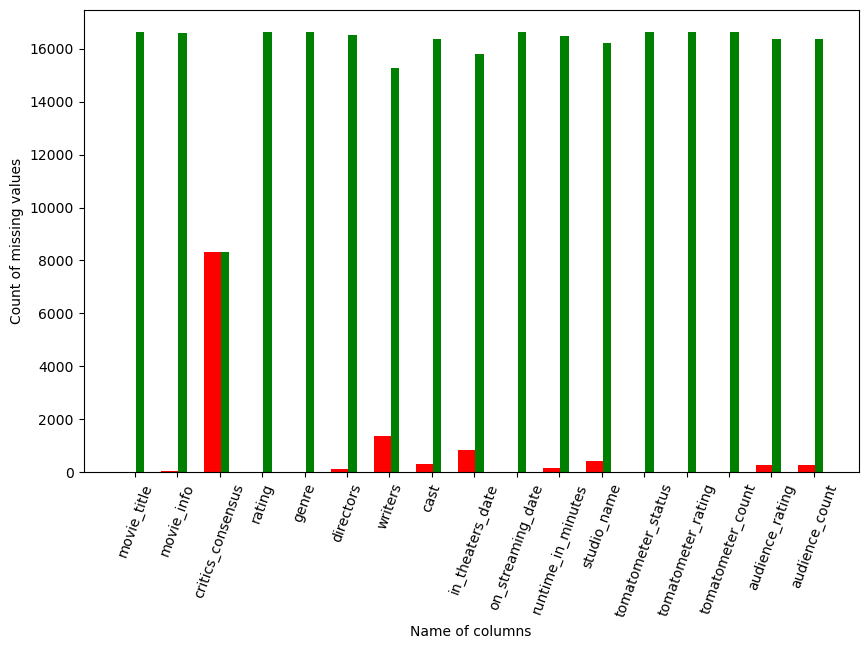

In [205]:
import numpy as np
from matplotlib import pyplot as plt

nulls = []
for col in data.columns:
    cnt = Counter(data[col].notnull())
    nulls.append((col, cnt))

fig, ax = plt.subplots(figsize=(10, 6))
for i,(name,cnt_data) in enumerate(nulls):
    ax.bar(i*4,cnt_data[False], width=2, color='red', label='Null')
    ax.bar((i*4)+1,cnt_data[True], color='green',label='Not null')
    
ax.set_xticks(ticks=np.arange(len(data.columns))*4+0.5,rotation=70,labels=data.columns)
ax.set_xlabel("Name of columns")
ax.set_ylabel("Count of missing values")
plt.show()

> 📝 <span style="color:lightblue">Komentarz:</span> Istotnie niektóre z tych kategori wydają się być niestotne do brania pod uwagę podczas naszego przyrównywania, na przykład oceny użytkowników, albo krytyków, tak naprawdę jeżeli chcemy mieć dobry film podobny tematycznie do siebie to niekoniecznie oceny te też będą do siebie zbliżone. Czas trwania ma znaczenie, chociaż jak zaraz zobaczymy, jest on również różnej długości, tutaj będziemy mieli ten sam problem co w wypadku naszych tweetów vs posty. Zobaczmy rozkład dancyh numerycznych

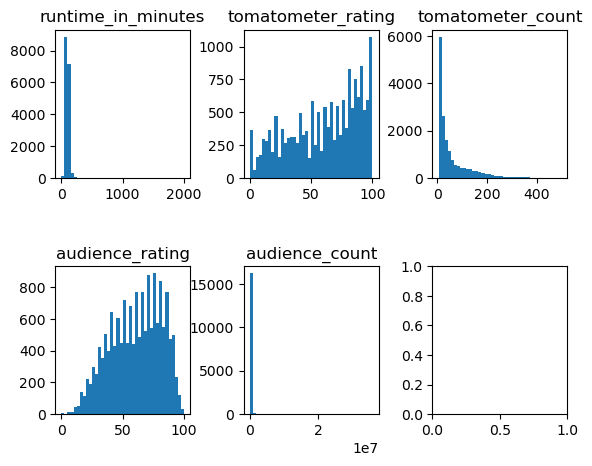

In [206]:
fix,axs = plt.subplots(nrows=2,ncols=3)
for ax,col in zip(axs.flatten(),numeric_labels):
    ax.hist(x=data[col], bins=40)
    ax.set_title(col)
    
plt.subplots_adjust(
    left=0.1,    # Space from the left edge of the figure
    right=0.9,   # Space from the right edge of the figure
    top=0.9,     # Space from the top edge of the figure
    bottom=0.1,  # Space from the bottom edge of the figure
    wspace=0.4,  # Width space between subplots
    hspace=0.6   # Height space between subplots
)
plt.show()


> 📝 <span style="color:lightblue">Komentarz:</span> Istotnie dużo takich różnych wartości skrajnych, ale zobaczymy, czy będą one przydatne do klasyfikacji

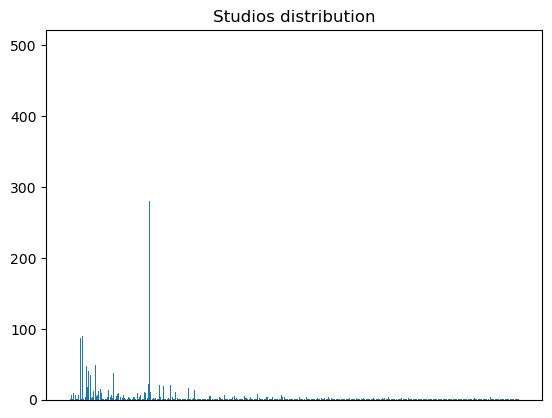

In [207]:
cnt = Counter(data['studio_name'])
studios, count = list(cnt.keys()), list(cnt.values())
studios = list(map(lambda x: str(x),studios))
plt.bar(studios, count)
plt.xticks([],[])
plt.title("Studios distribution")
plt.show()

> 📝 <span style="color:lightblue">Komentarz:</span> Widzimy tutaj, jak dużo jest poszczególnych studio, widzimy, że jest kilka takich, które naprawdę wypuściły dużo filmów, ale są i też takie które mają ich mało

## <span style="color:#6042f5"><b>Preprocessing

#### <span style="color:#eb8c34"><b>Łączenie danych i usuwanie zbędnych informacji oraz ekodowanie informacji

In [208]:
def remove_punctuation(text):
    # if text is not str:
    #     print(text)
    #     return text
    text = str(text)
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [209]:
# deleting not important data
df = data.copy()
df.drop(['movie_title'],axis=1,inplace=True)
df.drop(['rating'], axis=1, inplace=True) 
df.drop(['in_theaters_date'], axis=1, inplace=True)
df.drop(['on_streaming_date'], axis=1, inplace=True)
df.drop(['runtime_in_minutes'], axis=1, inplace=True)
df.drop(['tomatometer_status', 'tomatometer_count', 'tomatometer_rating', 'audience_rating', 'audience_count'], axis=1, inplace=True)

# mashup a text feature
text_features = ['movie_info', 'critics_consensus', 'directors', 'writers', 'cast', 'studio_name']
df[text_features] = df[text_features].fillna('')
df['text'] = df.movie_info + ' ' + df.critics_consensus + ' ' + df.directors + ' ' + df.writers + ' ' + df.cast + ' ' + df.studio_name
df.drop(text_features, axis=1, inplace=True)
df['text'] = df['text'].apply(remove_punctuation)
df['text'] = df['text'].apply(lambda x: unicodedata.normalize('NFKC', x))

# encoding genre
df['genre'] = df['genre'].fillna('No-Category')
df['genre'] = df['genre'].map(lambda x: str(x).split(', '))
encoder = MultiLabelBinarizer()
encoder.fit(df.genre.values)

categories = encoder.transform(df.genre)
categories_df = pd.DataFrame(categories, columns=encoder.classes_, index=df.index)
categories_df.drop('No-Category', axis=1, inplace=True)

df = pd.concat([df, categories_df], axis=1)
df.drop('genre', axis=1, inplace=True)
df.head(5)

,text,Action & Adventure,Animation,Anime & Manga,Art House & International,Classics,Comedy,Cult Movies,Documentary,Drama,...,Horror,Kids & Family,Musical & Performing Arts,Mystery & Suspense,Romance,Science Fiction & Fantasy,Special Interest,Sports & Fitness,Television,Western
0,A teenager discovers hes the descendant of a G...,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,Kate has a lot on her mind Theres the ethics p...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Blake Edwards 10 stars Dudley Moore as George ...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,A Puerto Rican youth is on trial for murder ac...,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,This 1954 Disney version of Jules Vernes 20000...,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


> 📝 <span style="color:lightblue">Komentarz:</span> A więc:
> - `movie_title`: w zasadzie nazwa nie dużo zawsze mówi o filmie, więcej powie nam opis oraz oceny krytyków, co istotne zostawiłem go w dataframie na potrzeby późniejszej wizualizacji
> - `rating`: tutaj głównie kategoria wiekowa na wstępie pominę ją zobaczymy jakie będą wyniki, choć na pierwszy rzut oka wydaję się ona nie wnosić dużo do charakterystyki filmu
> - `in_theaters_date/on_streaming_date`: wszystkie te wartości liczbowe wydają się nie specyfikować jakoś bardziej filmu, bo jak chcemy dostać film akcji z Keano Reves to średnio nasz będzie interesowało, czy film był kręcony w 1970 roku czy też 2010 :)
> - `...status/...count/...rating`: cała ta lista zostałą wyrzucona, że tak naprawdę nie interesuje nasz to jak dobry jest film, ale czego on dotyczy
> - `runtime_in_minutes`: w zasadzie aby nie zaburzać sobie analizy za pomocą outlinerów(bo czasami są jakieś filmy po 3 minuty itd, takie losowe dane), to wyrzuce te dane, w zasadzie filmy zazwyczaj maja po 2h dlugości, więc nie powinno to znacząco wpłynąć na naszą charakterystykę filmu
> 
> ***Apropo*** łączenia danych, to wszystkie dane tekstowe połączyłem w jedną całość oraz usunąłem z nich kropki, przecinki itp. , poza danymi takimi jak `genre`, je zakodowałem za pomocą wielklasowego OneHotEncoding, czyli MultiLabelBinarizer. Teraz przejdę do predykcji

## <span style="color:#6042f5"><b>Making predictions

#### <span style="color:#eb8c34"><b>CountVectorizer

In [210]:
counter = CountVectorizer(stop_words="english")
counter.fit(df.text.values)
vec_count = counter.transform(df.text.values)
vec_count = sp.hstack([vec_count, df[categories_df.columns].values])

> 📝 <span style="color:lightblue">Komentarz:</span> Najpierw zobaczmy jakie dostajemy wyniki, kiedy użyjemy naszego countVectorizera, narazie bez uzycia tf-idf. Zobaczymy podobieństwo na różnych metrykach. Weźmy sobie losowy film i postarajmy się znaleźć, jakąś podobną sugestię. Proponuje film o nazwie 'KickBoxer' o indeksie 615 w naszej bazie. Jest to film o kickboxerze, ktory chce sie zemstic na oprawcach, ktorzy sparaliżowali jego brata, zobaczymy czy uda się coś znaleźć.

In [211]:
def calculate_dist(unit, base, metric='euclidean'):
    dist = pairwise_distances(X=unit, Y=base, metric=metric)
    df_dist = pd.DataFrame({
        "movie_name": data.movie_title.values,
        "movie_info": data.movie_info.values,
        "dist": dist[0]
    })
    df_dist.sort_values(by=['dist'], ascending=True, inplace=True)
    return df_dist
    

##### <span style="color:#fce76f"><b>Euclidean Metric

In [212]:
kickboxer = counter.transform([df.loc[534].text])
kickboxer = sp.hstack([kickboxer, [df.loc[534][categories_df.columns].values.tolist()]])

In [213]:
calculate_dist(kickboxer, vec_count).head(5)

,movie_name,movie_info,dist
534,Kickboxer,Jean-Claude Van Damme enters a Thai kickboxing...,0.000000
14168,The Go-Getters,NaN,10.583005
10268,Mysteries Of The Jesus Prayer,NaN,10.630146
4850,Dana Carvey - Squatting Monkeys Tell No Lies,NaN,10.677078
14651,The Other Side of Everything (Druga strana svega),NaN,10.723805


##### <span style="color:#fce76f"><b>Cosine Metric

In [214]:
calculate_dist(kickboxer, vec_count, metric="cosine").head(5)

,movie_name,movie_info,dist
534,Kickboxer,Jean-Claude Van Damme enters a Thai kickboxing...,0.000000
8566,Knock Off,Against the drama and pageantry of the 1997 Br...,0.723297
5382,Double Impact,"When their parents are cruelly murdered, ident...",0.726209
5437,Dragon: The Bruce Lee Story,The brief but eventful life of actor and marti...,0.756083
3590,Bloodsport,U.S. soldier Frank Dux (Jean-Claude Van Damme)...,0.763942


#### <span style="color:#eb8c34"><b>TF-IDF


In [215]:
pipeline = Pipeline([
    ('vectorize', CountVectorizer(stop_words="english")),
    ('tf-idf', TfidfTransformer(smooth_idf=False))
])

vec_tfidf = pipeline.fit_transform(df.text.values)
vec_tfidf = sp.hstack([vec_tfidf, df[categories_df.columns].values])
kickboxer_tfidf = pipeline.transform([df.loc[534].text])
kickboxer_tfidf = sp.hstack([kickboxer_tfidf, [df.loc[534][categories_df.columns].values.tolist()]])

##### <span style="color:#fce76f"><b>Euclidean Metric

In [216]:
calculate_dist(kickboxer_tfidf, vec_tfidf).head(5)

,movie_name,movie_info,dist
534,Kickboxer,Jean-Claude Van Damme enters a Thai kickboxing...,0.000000
8432,Kickboxer: Retaliation,One year after finding vengeance for his murde...,1.345824
5437,Dragon: The Bruce Lee Story,The brief but eventful life of actor and marti...,1.347369
12418,Shaolin,As feuding warlords fight to expand their powe...,1.347663
8433,Kickboxer: Vengeance,After his brother is brutally killed by the fi...,1.352700


##### <span style="color:#fce76f"><b>Cosine Metric

In [217]:
calculate_dist(kickboxer_tfidf, vec_tfidf, "cosine").head(5)

,movie_name,movie_info,dist
534,Kickboxer,Jean-Claude Van Damme enters a Thai kickboxing...,0.000000
8432,Kickboxer: Retaliation,One year after finding vengeance for his murde...,0.301874
5437,Dragon: The Bruce Lee Story,The brief but eventful life of actor and marti...,0.302567
12418,Shaolin,As feuding warlords fight to expand their powe...,0.302699
8433,Kickboxer: Vengeance,After his brother is brutally killed by the fi...,0.304966


## <span style="color:#6042f5"><b>Let's try to cluster the data
- but what if we want to create a clusters of data? We want all the films that seems similar to the other film? We create the clusters then


##### <span style="color:#fce76f"><b>K-means

In [226]:
n_clusters = 60
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(vec_tfidf)

KMeans(n_clusters=60)

In [227]:
print(f"Cluster sizes:\n{Counter(kmeans.labels_)}",
      f"Within-cluster Sum of Squares (WCSS):\n{kmeans.inertia_}", sep='\n')

Cluster sizes:
Counter({25: 1733, 22: 1257, 8: 877, 15: 739, 9: 682, 10: 641, 3: 552, 17: 497, 27: 487, 12: 467, 47: 392, 24: 387, 0: 386, 13: 386, 6: 377, 11: 336, 4: 312, 35: 293, 14: 273, 50: 262, 42: 250, 23: 240, 7: 237, 29: 224, 39: 213, 41: 206, 36: 202, 20: 202, 46: 178, 18: 172, 34: 171, 49: 156, 37: 151, 59: 151, 54: 148, 33: 147, 53: 146, 51: 142, 43: 141, 56: 127, 31: 122, 58: 120, 38: 119, 28: 118, 16: 113, 57: 108, 30: 98, 48: 97, 45: 90, 55: 90, 44: 85, 32: 84, 26: 81, 19: 73, 40: 68, 2: 64, 1: 55, 52: 48, 5: 41, 21: 24})
Within-cluster Sum of Squares (WCSS):
21227.25867069775


In [228]:
clusters_df = pd.DataFrame({
    'name': data.movie_title.values,
    'info': data.movie_info.values,
    'cluster': kmeans.labels_
})
index_cluster4 = clusters_df[clusters_df['cluster'] == 21].index
data.loc[index_cluster4]

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,audience_count
2012,A Bigger Splash,"In A BIGGER SPLASH, rock legend Marianne Lane ...","Absorbing, visually arresting, and powerfully ...",R,"Art House & International, Drama, Mystery & Su...",Luca Guadagnino,David Kajganich,"Ralph Fiennes, Dakota Johnson, Matthias Schoen...",2016-05-04,2016-09-06,124.0,StudioCanal,Certified Fresh,90,178,57.0,8525.0
3599,Blue Caprice,The striking feature film debut of writer-dire...,"Smart, sobering, and quietly chilling, Blue Ca...",R,"Drama, Mystery & Suspense, Special Interest",Alexandre Moors,"Alexandre Moors, R.F.I. Porto","Isaiah Washington, Tequan Richmond, Tim Blake ...",2013-09-13,2014-01-14,93.0,IFC Films,Certified Fresh,83,82,51.0,7248.0
3795,Breaking The Girls,In a thriller reminiscent of the best of Alfre...,NaN,NR,"Drama, Mystery & Suspense, Special Interest",Jamie Babbit,"Guinevere Turner, Mark Distefano","Agnes Bruckner, Madeline Zima, Shawn Ashmore, ...",2013-07-26,2013-11-19,85.0,IFC Films,Rotten,11,9,29.0,357.0
4087,Captive,A thrilling drama about the spiritual collisio...,Captive undermines committed performances from...,PG-13,"Drama, Mystery & Suspense, Special Interest",Jerry Jameson,Brian Bird,"Kate Mara, David Oyelowo, Michael Kenneth Will...",2015-09-18,2016-01-05,97.0,Paramount Pictures,Rotten,27,52,43.0,4818.0
4576,Compliance,Becky and Sandra aren't the best of friends. S...,"Anchored by smart, sensitive direction and str...",R,"Drama, Mystery & Suspense, Special Interest",Craig Zobel,Craig Zobel,"Ann Dowd, Dreama Walker, Pat Healy, Bill Camp,...",2012-08-17,2013-01-08,90.0,Magnolia Pictures,Certified Fresh,89,141,60.0,13875.0
5313,Dogville,"The beautiful fugitive, Grace, arrives in the ...",A challenging piece of experimental filmmaking.,R,"Art House & International, Drama, Mystery & Su...",Lars von Trier,"Lars von Trier, Linda Daae","Nicole Kidman, Paul Bettany, Harriet Andersson...",2003-05-01,2004-08-24,177.0,Lions Gate Films,Fresh,70,167,89.0,55261.0
5719,Enter the Void (Soudain le vide),"ENTER THE VOID, the psychedelic thriller by vi...","Grimy and psychedelic, Enter the Void ushers a...",NR,"Art House & International, Drama, Mystery & Su...",Gaspar Noé,Gaspar Noé,"Paz de la Huerta, Nathaniel Brown, Cyril Roy, ...",2010-09-24,2011-01-25,137.0,IFC Films,Fresh,71,91,71.0,14325.0
7165,Headshot,A darkly turbulent crime noir from Thai new wa...,NaN,NR,"Art House & International, Mystery & Suspense,...",Pen-Ek Ratanaruang,Pen-Ek Ratanaruang,"Jayanama Nopachai, Sirin Horwang, Chanokporn ""...",2012-09-28,2012-10-02,105.0,Kino Lorber,Fresh,69,13,48.0,1278.0
8840,Legend,From Academy Award (R) winner Brian Helgeland ...,"As a gangster biopic, Legend is deeply flawed,...",R,"Art House & International, Mystery & Suspense,...",Brian Helgeland,Brian Helgeland,"Tom Hardy, Emily Browning, David Thewlis, Chri...",2015-11-20,2016-03-01,132.0,Universal Studios,Fresh,61,169,59.0,28195.0
9575,Marshland (La isla mínima),"The Spanish deep South, 1980. A series of brut...",As narratively taut as it is richly atmospheri...,NR,"Art House & International, Mystery & Suspense,...",Alberto Rodríguez,"Alberto Rodríguez, Rafael Cobos","Javier Gutiérrez, Raúl Arévalo, María Varod, M...",NaN,2016-02-09,105.0,AXN,Fresh,92,36,77.0,1081.0
